#### <b>Introduction</b> 
Having implemented a neural network from scratch using for loops, we will now be using vectorization (wherever applicable) to improve the performance of the model and equip it to deal with the complete Fashion MNIST Dataset.

The dataset consists of 70,000 images of fashion/clothing items belonging to 10 different categories/classes. It has furhter been divided into 60,000 training images and 10,000 test images and each image is a 28*28 grayscale image (hence 1 color channel). It is recommended that you go through  [this link](https://www.kaggle.com/zalando-research/fashionmnist) to familiarize yourself with the dataset.

In this phase, we will load the required dataset from the keras datasets library.

In [8]:
# making all the necessary imports here

import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from IPython.display import Image
import pydot
from tqdm import tqdm_notebook
import seaborn as sns
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.datasets import make_moons
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from google.colab import drive
import glob
import cv2


In [9]:
# This function will be used to plot the confusion matrix at the end of this notebook

def plot_confusion_matrix(conf_mat):
    classes = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(15,9))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

class_labels = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [10]:
# Random number that will be used for plotting purposes

rollnumber = 2410010

#### __Dataset from Keras Library__

The required library has been imported for you as fashion_mnist. Use it to load the train and test data accordingly.

In [11]:
classes = 10 # Do not change this

# Download Fashion MNIST dataset
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()

# Split the fashion MNIST dataset into train and test sets
# Convert y_train and y_test to categorical binary values 
x_train = x_train/255.0
x_test = x_test/255.0

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
#Reshape train and test images as one-dimensional arrays

x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)

trainX = x_train
trainy = y_train

In [12]:
from re import L
class NeuralNetwork():
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        return (-np.sum(y_true * np.log(y_pred)))/len(y_true)

    @staticmethod
    def accuracy(y_pred, y_true):
        correct_predictions = 0
        total = len(y_pred)
        for i in range(total):
          if y_pred[i] == y_true[i]:
            correct_predictions += 1
        accuracy = (correct_predictions/total)* 100
        return accuracy

    @staticmethod
    def softmax(x):
        denom = np.sum(np.exp(x))
        softmax_array = np.divide(np.exp(x),denom)
        return softmax_array

    @staticmethod
    def sigmoid(x):
        denom = 1 + np.exp(-x)
        return 1/denom

    def __init__(self, nodes_per_layer):
        '''Creates a Feed-Forward Neural Network.
        The parameters represent the number of nodes in each layer. 
        Look at the inputs to the function, and use 'try and accept'
        to catch errors if number of layers are < 2.
        '''
        if len(nodes_per_layer)<4:
          raise Exception ("Sorry, not enough hidden layers")
        self.num_layers = len(nodes_per_layer) # including input and output layers
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[-1]

        self.weights_ = []
        self.biases_ = []
        self.__init_weights(nodes_per_layer)

    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        '''Initialize weights for each layer except the input layer, since it does not have weights.'''
        
        for i in range(len(nodes_per_layer)-1):
          temp_weights = np.random.normal(size=(nodes_per_layer[i],nodes_per_layer[i+1]))
          self.weights_.append(temp_weights)
          temp_biases = np.zeros(shape=(nodes_per_layer[i+1]),)
          self.biases_.append(temp_biases)

    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        
        activations = []
        input = input_data[0]

        #hidden_layers
        for i in range(len(self.weights_)-1):
          aggregate = np.dot(input,self.weights_[i]) + self.biases_[i]
          activation = self.sigmoid(aggregate)
          
          activations.append(activation)
          input = activation

        #output layer
        input = activations[-1]
        aggregate = np.dot(input,self.weights_[-1]) + self.biases_[-1]
        activation = self.softmax(aggregate)
        activations.append(activation)
              
        return activations

    def sigmoid_derivative(self, x):
      return x*(1-x)

    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
                
        # suppose [784,x,y,z,10] [784, 40, 30, 20, 10]
        # w_h1 is [784,x]     a_h1 [x]
        # w_h2 is [x,y]       a_h2 [y]
        # w_h3 is [y,z]  [30,20]]   a_h3 [z] [20]
        # w_o is [z,10] [20,10]      a_o [10]

        deltas = []
        deltas_weights = []
        deltas_biases = []
        #output_layer
        layer_activations = np.array(layer_activations) 
        l_activations = layer_activations.copy()
        l_activations = np.flip(l_activations)

        error_in_output_layer =  l_activations[0] - targets
        d_error_wrt_w_o = np.dot( np.reshape(l_activations[1],(len(l_activations[1]),1)) , error_in_output_layer)
        delta_for_w_o = d_error_wrt_w_o
        delta_for_b_o = np.transpose(error_in_output_layer)

        deltas_weights.append(delta_for_w_o)
        deltas_biases.append(delta_for_b_o)

        #hidden_layer
        error_in_next_layer = error_in_output_layer[0]
        weights = self.weights_.copy()
        weights.reverse()
        
         #error_in_hidden_layer = ( w_originating_from_this_layer . error_in_next_layer )  *  der_sigmoid( activation_originating_from_this_layer )
        # 20                  =   [20,10].[10]  *    20
        # 20                   =   20 * 20
        
        for i in range(self.num_layers-2): # (0,3) - 0,1,2
          error_in_next_layer = np.reshape(error_in_next_layer, (len(error_in_next_layer),1) )
          error_in_hidden_layer = np.dot( weights[i] , error_in_next_layer ) * self.sigmoid_derivative( np.reshape(l_activations[i+1],(len(l_activations[i+1]),1)) )

          if i == (self.num_layers-3): #as we dont have input for first hidden layer
            delta_for_w_h = error_in_hidden_layer
            delta_for_b_h = error_in_hidden_layer
            deltas_weights.append(delta_for_w_h)
            deltas_biases.append(delta_for_b_h)
            break
          
          delta_for_w_h = np.dot( np.reshape(l_activations[i+2],(len(l_activations[i+2]),1)) , np.transpose(error_in_hidden_layer))
          delta_for_b_h = error_in_hidden_layer

          deltas_weights.append(delta_for_w_h)
          deltas_biases.append(delta_for_b_h)
       
          error_in_next_layer = error_in_hidden_layer
        
        
        deltas.append(deltas_weights)
        deltas.append(deltas_biases)
        return deltas


    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        
        delta_weights = deltas[0] # [wo,wh3,wh2,wh1]
        delta_biases = deltas[1] # [b0,bh3,bh2,bh1]
        
        delta_weights[-1] = np.transpose( np.dot( delta_weights[-1] , layer_inputs[0]) )
        
        delta_weights.reverse()
        delta_biases.reverse()

        for i in range(len(delta_biases)):
          
          delta_biases[i] = np.transpose(delta_biases[i])[0]

        
        for w in range(len(self.weights_)):
          self.weights_[w] = self.weights_[w] - ( lr*delta_weights[w] )
          self.biases_[w] = self.biases_[w] - ( lr*delta_biases[w] )

        
    def fit(self, Xs, Ys, epochs, lr=1e-3):
            history = []
            for epoch in tqdm_notebook(range(epochs)):
                num_samples = Xs.shape[0]
                
                for i in range(num_samples):
                    sample_input = Xs[i,:].reshape((1,self.input_shape))
                    sample_target = Ys[i,:].reshape((1,self.output_shape))
                    
                    activations = self.forward_pass(sample_input)   # Call forward_pass function 
                    deltas = self.backward_pass(sample_target, activations)    # Call backward_pass function 
                    
                    layer_inputs = [sample_input] + activations[:-1]
                    
                    # Call weight_update function 
                    self.weight_update(deltas, layer_inputs, lr)
                    
                
                preds = self.predict(Xs)   # Call predict function 

                current_loss = self.cross_entropy_loss(preds, Ys)
                
                if  epoch==epochs-1:
                  confusion_mat=confusion_matrix(Ys.argmax(axis=1), preds.argmax(axis=1),labels=np.arange(10))  
                  plot_confusion_matrix(confusion_mat)
                  report = classification_report(Ys, np_utils.to_categorical(preds.argmax(axis=1),num_classes=classes), target_names=class_labels)
                  print(report)
                history.append(current_loss)
            return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            sample = Xs[i,:].reshape((1,self.input_shape))
            sample_prediction = self.forward_pass(sample)[-1]
            predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        nodes_per_layer = [self.input_shape, self.hidden_shape, self.output_shape]
        for i in range(self.num_layers-1):
            for n1 in range(nodes_per_layer[i]):
                for n2 in range(nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

In [13]:
# These are what we call the hyperparameters 
EPOCH = 100           # must be an int
LEARNING_RATE = 0.001
nodes_per_layer = [784, 60, 50, 40, 30, 10]  #int values for nodes of each layer. # of hidden layers >= 2. 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


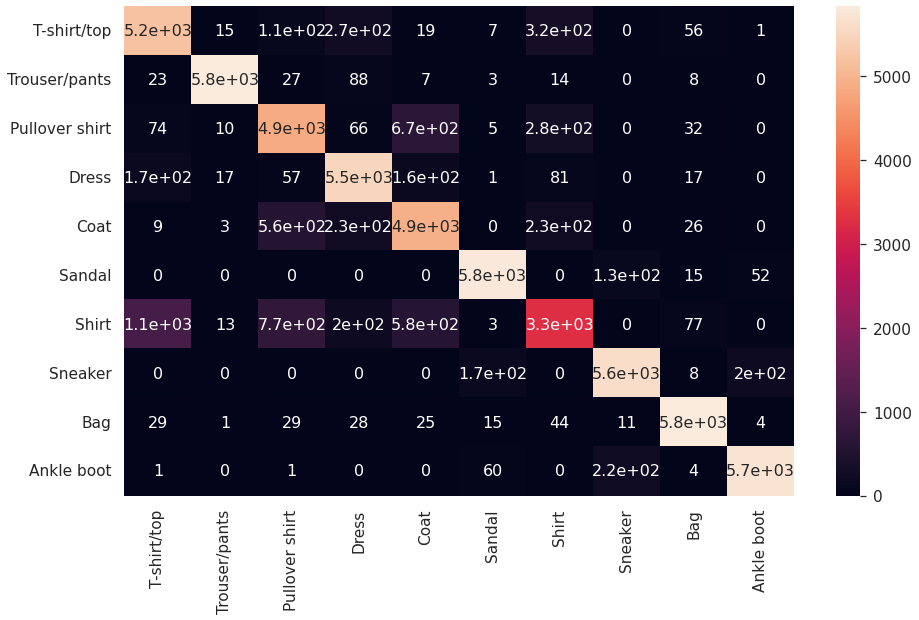

                precision    recall  f1-score   support

   T-shirt/top       0.79      0.87      0.83      6000
 Trouser/pants       0.99      0.97      0.98      6000
Pullover shirt       0.76      0.81      0.78      6000
         Dress       0.86      0.92      0.89      6000
          Coat       0.77      0.82      0.80      6000
        Sandal       0.96      0.97      0.96      6000
         Shirt       0.77      0.55      0.64      6000
       Sneaker       0.94      0.94      0.94      6000
           Bag       0.96      0.97      0.96      6000
    Ankle boot       0.96      0.95      0.95      6000

     micro avg       0.88      0.88      0.88     60000
     macro avg       0.88      0.88      0.87     60000
  weighted avg       0.88      0.88      0.87     60000
   samples avg       0.88      0.88      0.88     60000

Runtime of the algorithm is  5237.287  seconds
(0.44939680418929645, 83.89999999999999)


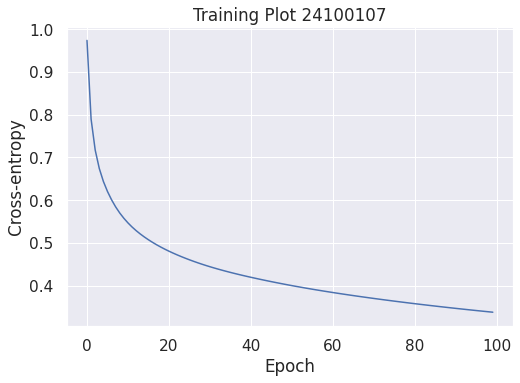

In [14]:
start = time.time()

# Instantiate the neural network with the number of nodes you choose per layer, right now it is done for three layers only.
nn = NeuralNetwork(nodes_per_layer=nodes_per_layer)
history = nn.fit(trainX, trainy, epochs=EPOCH, lr=LEARNING_RATE)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber));
end = time.time()

print("Runtime of the algorithm is ", round((end - start),3)," seconds")

# print accuracy on test set here
print(nn.evaluate(x_test,y_test))